This document is the property of Noodle AI and has been generated for the specific purpose of Noodle AI's Data Science hiring process, utilizing publicly available data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\Users\rakla\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rakla\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\rakla\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
pd.options.display.max_rows=100
pd.pandas.set_option('display.max_columns', None)

# Load Data

## Description

`data.csv`: This is the historical training data, which covers 2010–02–05 to 2012–11–01. Within this file you will find the following fields:
    
    - ts_key: The key of the time-series. It's a concatenation of Store and Dept.
    - Store: The store number
    - Dept: The department number
    - Date: The week
    - Weekly_Sales: Sales for the given department in the given store
    - IsHoliday: Whether the week is a special holiday week
    - Date: The week
    - Temperature: Average temperature in the region (Fahrenheit)
    - Fuel_Price: Cost of fuel in the region
    - MarkDown1: Anonymized data related to promotional markdowns that Walmart is running
    - MarkDown2: Anonymized data related to promotional markdowns that Walmart is running
    - MarkDown3: Anonymized data related to promotional markdowns that Walmart is running
    - MarkDown4: Anonymized data related to promotional markdowns that Walmart is running
    - MarkDown5: Anonymized data related to promotional markdowns that Walmart is running
    - CPI: The consumer price index. It measures the monthly changes in prices paid by US consumers
    - Type: Store type has been provided, there are 3 types — A, B and C
    - Size: Stores size has provided

## Validation Period

For validation, please provide metrics for a 3-week horizon over the dates [2012-10-12, 2012-10-19, 2012-10-26]. In other words, the last date in your training dataset should be 2012-10-05. We expect to see the results of your tuning over this period, not just final metrics.

## Data

In [4]:
data = pd.read_csv("../data/raw/data.csv")

C:\Users\rakla\AppData\Local\Temp\ipykernel_29400\1648978209.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/raw/data.csv")


We're predicting `Weekly_Sales` at a forecast horizon of `h=3` at a granularity of `Store/Dept`. There are 3331 unique time-series to forecast.

The categorical features are:
- Type
- IsHoliday
- Store
- Dept

The continuous features are:
- Size
- Temperature
- Fuel_Price
- MarkDown{1-5}
- CPI
- Unemployment

In [5]:
cat_vars = ["IsHoliday", "Type", "Store", "Dept"]
num_vars = ["Size", "Temperature", "Fuel_Price", "CPI", "Unemployment"] + [x for x in data.columns if "MarkDown" in x]

In [8]:
data['IsHoliday'].value_counts()

False    128256
True       9734
Name: IsHoliday, dtype: int64

# Series Length

Please note that not all series are created equal. Although most series have 143 weeks of history, many have far fewer. How will you handle these series in your models? Let us know in your write-up!

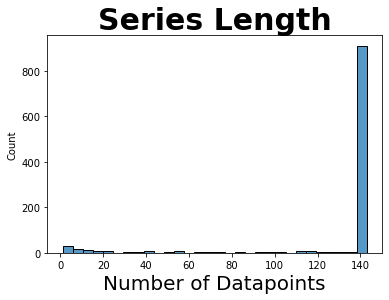

In [14]:
sns.histplot(data=data[["ts_key", "Date"]].groupby("ts_key").count().reset_index(), x="Date", bins=30)
plt.title("Series Length", fontsize=30, fontweight="bold")
plt.xlabel("Number of Datapoints", fontsize=20)

plt.show()

# Weekly Sales

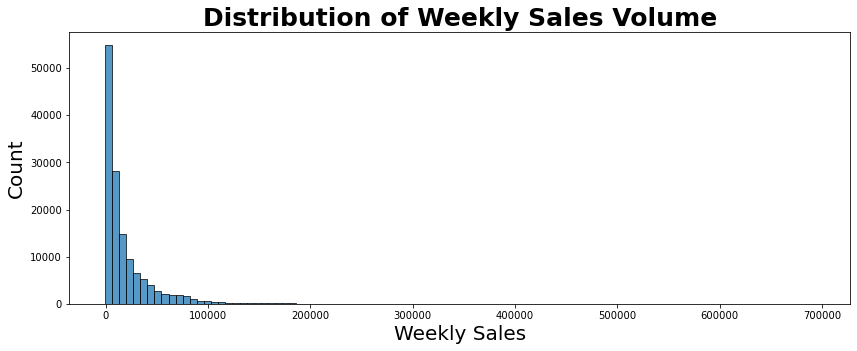

In [15]:
fig, ax = plt.subplots(1,1,figsize=(14, 5))

sns.histplot(data=data, x="Weekly_Sales", bins=100)
ax.set_xlabel("Weekly Sales", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title("Distribution of Weekly Sales Volume", fontsize=25, fontweight='bold')
plt.show()


# Autoregressive

Below are the distributions of ACF values across all time-series present for a lag of 26 weeks. How do the graphs inform your process of generating features and choosing a model? If they're helpful, tell us why in your write-up.

In [17]:
n_lags = 26
acf = np.zeros((len(data["ts_key"].unique()), n_lags))
short_series = []
for idx, key in enumerate(data["ts_key"].unique()):
    try:
        acf[idx, :] = sm.tsa.stattools.acf(data.loc[data["ts_key"] == key, ["Date", "Weekly_Sales"]].set_index("Date"), nlags=n_lags-1)
    except ValueError:
        short_series.append(idx)

C:\Users\rakla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\rakla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\rakla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\rakla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\rakla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\rakla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] /

In [18]:
acf_df = pd.DataFrame(acf, columns=[f"lag_{i}" for i in range(n_lags)])
acf_df = acf_df[~acf_df.index.isin(short_series)]
acf_df = acf_df.melt(var_name="lag", value_name="acf")

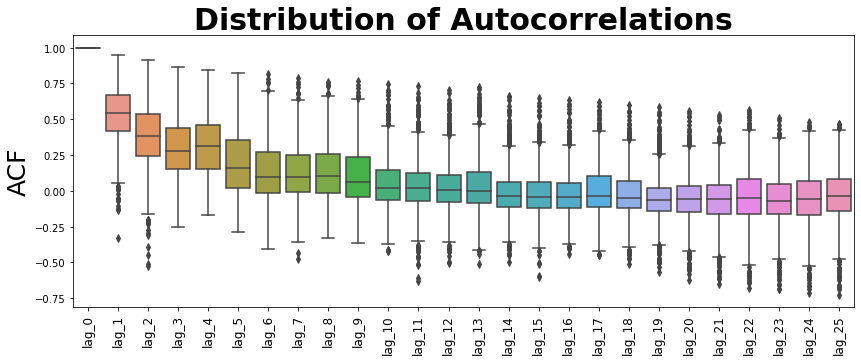

In [19]:
fig, ax = plt.subplots(1,1,figsize=(14, 5))

sns.boxplot(data=acf_df, x="lag", y="acf", ax=ax)
ax.set_xlabel("", fontsize=25)
ax.set_ylabel("ACF", fontsize=25)
ax.set_title("Distribution of Autocorrelations", fontsize=30, fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=90)
plt.show()

# Numerical Features

Use the plots below to inform your understanding of the numerical features. Include any useful insights you've gleaned in your final write-up and discuss how these plots informed any modeling decisions you made.

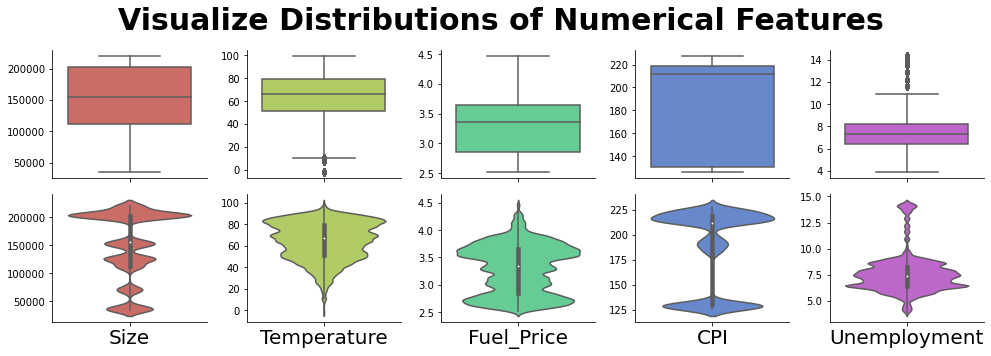

In [20]:
long_data = data[num_vars].melt(var_name="feature")
#what does melt do?
#https://www.geeksforgeeks.org/python-pandas-melt/
fig, ax = plt.subplots(2, 5,figsize=(14, 5))

palette = sns.color_palette("hls", 5)

for idx, feature in enumerate([x for x in num_vars if "MarkDown" not in x]):
    sns.boxplot(data=long_data[long_data["feature"] == feature], x="feature", y="value", ax=ax[0, idx], color=palette[idx])
    sns.violinplot(data=long_data[long_data["feature"] == feature], x="feature", y="value", ax=ax[1, idx], color=palette[idx])
    ax[0, idx].set_xlabel("")
    ax[0, idx].set_ylabel("")
    ax[0, idx].set_xticklabels([])
    ax[0, idx].spines['top'].set_visible(False)
    ax[0, idx].spines['right'].set_visible(False)
    ax[1, idx].set_xlabel("")
    ax[1, idx].set_ylabel("")
    ax[1, idx].set_xticklabels([feature], fontsize=20)
    ax[1, idx].spines['top'].set_visible(False)
    ax[1, idx].spines['right'].set_visible(False)

plt.suptitle("Visualize Distributions of Numerical Features", fontsize=30, fontweight="bold")
plt.tight_layout()

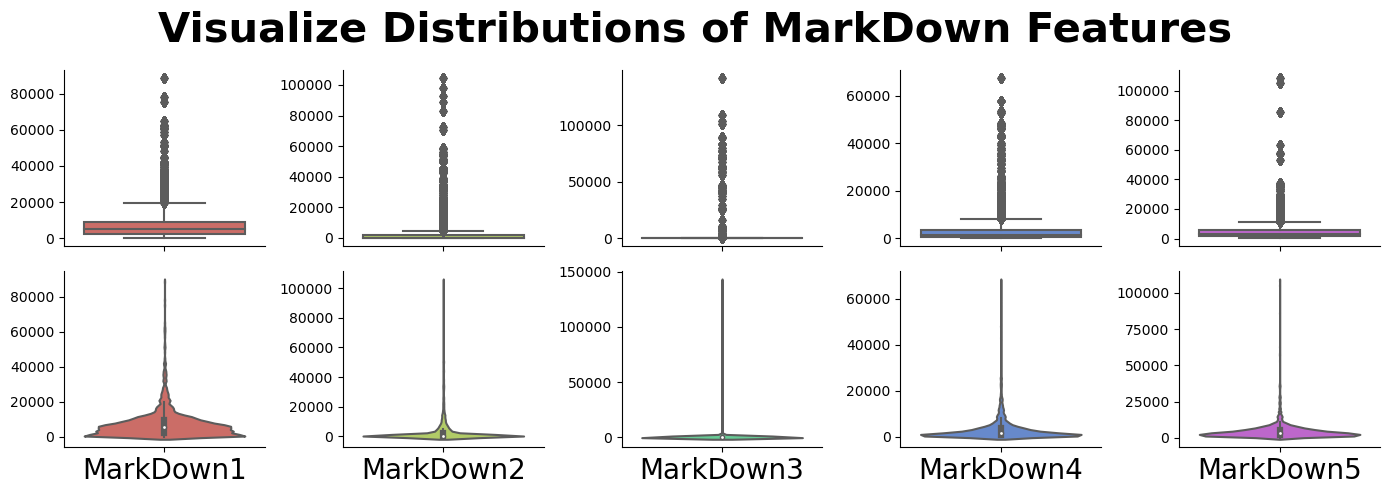

In [ ]:
long_data = data[num_vars].melt(var_name="feature")

fig, ax = plt.subplots(2, 5,figsize=(14, 5))

palette = sns.color_palette("hls", 5)

for idx, feature in enumerate([x for x in num_vars if "MarkDown" in x]):
    sns.boxplot(data=long_data[long_data["feature"] == feature], x="feature", y="value", ax=ax[0, idx], color=palette[idx])
    sns.violinplot(data=long_data[long_data["feature"] == feature], x="feature", y="value", ax=ax[1, idx], color=palette[idx])
    ax[0, idx].set_xlabel("")
    ax[0, idx].set_ylabel("")
    ax[0, idx].set_xticklabels([])
    ax[0, idx].spines['top'].set_visible(False)
    ax[0, idx].spines['right'].set_visible(False)
    ax[1, idx].set_xlabel("")
    ax[1, idx].set_ylabel("")
    ax[1, idx].set_xticklabels([feature], fontsize=20)
    ax[1, idx].spines['top'].set_visible(False)
    ax[1, idx].spines['right'].set_visible(False)

plt.suptitle("Visualize Distributions of MarkDown Features", fontsize=30, fontweight="bold")
plt.tight_layout()

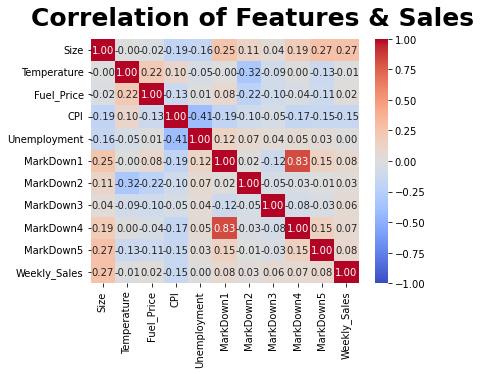

In [21]:
data[num_vars + ["Weekly_Sales"]].corr()

fig, ax = plt.subplots(1,1, figsize=(6,4.5))

plt.suptitle("Correlation of Features & Sales", fontsize=25, fontweight="bold")
sns.heatmap(
    data[num_vars + ["Weekly_Sales"]].corr(), 
    annot=True, fmt=".2f", cmap="coolwarm",
    vmin=-1, vmax=1, ax=ax
)
plt.show()

# Categorical Features

`IsHoliday` is a boolean categorical variable. `Type` has 3 values and describes the type of store. `Store` and `Dept` are both keys of the time-series to be modeled, and can thus be used as unique categorical features as well. Are there any analyses or EDA you want to do with these categorical features? If so, include them in your write-up and discuss their relevance.

In [22]:
data[cat_vars].nunique()

IsHoliday     2
Type          2
Store        14
Dept         80
dtype: int64

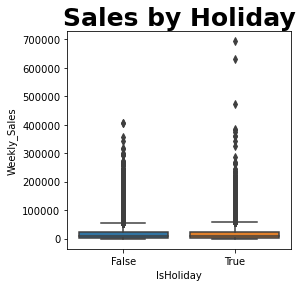

In [23]:
fig, ax = plt.subplots(1,1,figsize=(4, 4))

sns.boxplot(data=data, x="IsHoliday", y="Weekly_Sales")
ax.set_title("Sales by Holiday", fontsize=25, fontweight='bold')

plt.show()

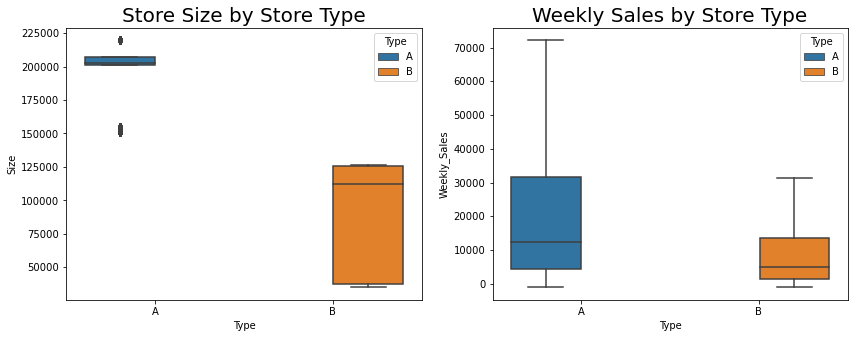

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data = data, x="Type", y="Size", hue="Type", ax=ax[0])
sns.boxplot(data = data, x="Type", y="Weekly_Sales", hue="Type", showfliers=False, ax=ax[1])

ax[0].set_title("Store Size by Store Type", fontsize=20)
ax[1].set_title("Weekly Sales by Store Type", fontsize=20)

plt.show()